# Multi-output model with wragged time measurements

This notebook describes how to fit a model in PINTS which has multiple outputs with different measurement times for each. Additionally, we illustrate how this same framework allows different measurement models to be used for different outputs within the same forward model when doing inference.

For this, we consider the [Goodwin-Oscillator](../toy/model-goodwin-oscillator.ipynb) model, which has three outputs.

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import pints.noise

We first create some simulated data.

In [2]:
model = pints.toy.GoodwinOscillatorModel()
real_parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(real_parameters, times)

# add noise
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

Now we assume that only the first half of time measurements are taken for the first two outputs; and only the second half for the third.

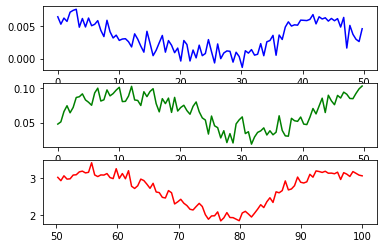

In [3]:
times_12 = times[:100]
outputs_12 = noisy_values[:100, :2]
times_3 = times[100:]
outputs_3 = noisy_values[100:, 2]

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times_12, outputs_12[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times_12, outputs_12[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times_3, outputs_3, 'r')
plt.show()

We now create a `ProblemCollection` that allows us to construct problems for each of the outputs.

In [6]:
collection = pints.ProblemCollection(model, times_12, outputs_12,
    times_3, outputs_3)
problem_0 = collection.subproblem(0)
problem_1 = collection.subproblem(1)

Each problem has a method for solving the ODE system.

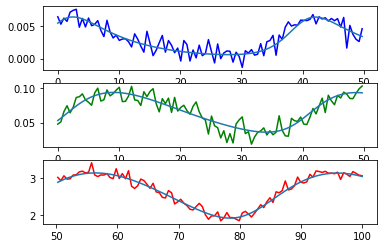

In [14]:
# solve system
sol_12 = problem_0.evaluate(real_parameters)

## this uses cached result from first solve under the hood
sol_3 = problem_1.evaluate(real_parameters)

# overlay ODE solutions over noisy data
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times_12, outputs_12[:, 0], 'b')
plt.plot(times_12, sol_12[:, 0])
plt.subplot(3, 1, 2)
plt.plot(times_12, outputs_12[:, 1], 'g')
plt.plot(times_12, sol_12[:, 1])
plt.subplot(3, 1, 3)
plt.plot(times_3, outputs_3, 'r')
plt.plot(times_3, sol_3)
plt.show()

## Inference
We now describe how we can perform inference for the overall system. Here, we assume different likelihoods for each of the two output chunks.

In [18]:
log_likelihood_0 = pints.GaussianKnownSigmaLogLikelihood(problem_0, [noise1, noise2])
log_likelihood_1 = pints.GaussianLogLikelihood(problem_1)

This means that each of our log-likelihoods have a different number of parameters:

In [21]:
log_likelihood_0.n_parameters()

5

In [22]:
log_likelihood_1.n_parameters()

6

We then aggregate these into a single callable object that we can use for inference.

In [35]:
class CombinedLogLikelihood(pints.LogPDF):
    def __init__(self, log_likelihood_0, log_likelihood_1):
        self._log_likelihood_0 = log_likelihood_0
        self._log_likelihood_1 = log_likelihood_1

    def __call__(self, x):
        return log_likelihood_0(x[:5]) + log_likelihood_1(x)

    def n_parameters(self):
        return 6
    
combined_log_likelihood = CombinedLogLikelihood(log_likelihood_0, log_likelihood_1)

Using this, we now perform maximum likelihood estimation.

In [38]:
# Define some boundaries
boundaries = pints.RectangularBoundaries([-5, -5], [5, 5])

# Pick an initial point at actual parameter values
x0 = real_parameters.tolist() + [noise3]

# And run!
xbest, fbest = pints.optimise(combined_log_likelihood, x0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Time m:s
0     9     -72.07721   0:00.2
1     18     561.0911   0:00.2
2     27     561.0911   0:00.3
3     36     925.9462   0:00.4
20    189    962.1331   0:01.4
40    369    967.3481   0:02.7
60    549    968.1981   0:03.9
80    729    968.257    0:05.1
100   909    968.2647   0:06.4
120   1089   968.3049   0:07.7
140   1269   968.3356   0:09.0
160   1449   968.3361   0:10.2
180   1629   968.3361   0:11.5
200   1809   968.3361   0:12.8
220   1989   968.3361   0:14.0
240   2169   968.3361   0:15.3
260   2349   968.3361   0:16.6
280   2529   968.3361   0:17.8
300   2709   968.3361   0:19.1
320   2889   968.3361   0:20.4
340   3069   968.3361   0:21.6
360   3249   968.3361   0:22.9
380   3429   968.3361   0:24.2
400   3609   968.3361   0:25.4
420   3789   968.3361   0:26.7
440   3969   968.3361   0:28.0
460   4149   968.3361   0:29.2
480 

In [40]:
xbest

array([1.97637205, 4.11780789, 0.11608288, 0.08182563, 0.1016085 ,
       0.09407352])

Now overlaying the estimated ODE solutions on top of the data.

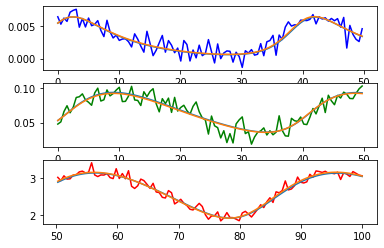

In [44]:
# solve system
sol_12_a = problem_0.evaluate(xbest[:5])

## this uses cached result from first solve under the hood
sol_3_a = problem_1.evaluate(xbest[:5])

# overlay ODE solutions over noisy data
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times_12, outputs_12[:, 0], 'b')
plt.plot(times_12, sol_12[:, 0])
plt.plot(times_12, sol_12_a[:, 0])
plt.subplot(3, 1, 2)
plt.plot(times_12, outputs_12[:, 1], 'g')
plt.plot(times_12, sol_12[:, 1])
plt.plot(times_12, sol_12_a[:, 1])
plt.subplot(3, 1, 3)
plt.plot(times_3, outputs_3, 'r')
plt.plot(times_3, sol_3)
plt.plot(times_3, sol_3_a)
plt.show()

The estimated solutions are close to the true solutions.